In [2]:
# Inspired by https://avandekleut.github.io/vae/
import torch;
import torch.nn as nn
import torch.utils
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
class FF(nn.Module):
    def __init__(self,dim1,dim2,dim3):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=dim1, out_features=dim2),
            nn.ReLU(),
            nn.Linear(in_features=dim2, out_features=dim3)
        )

    def forward(self, input):
        return self.main(input)

tmp = FF(28*28, 512, 2)
print(tmp)
print(tmp(torch.rand(10, 1, 28*28)).shape)

FF(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)
torch.Size([10, 1, 2])


In [5]:
class Autoencoder(nn.Module):
    def __init__(self, dim1, dim2, dim3):
        super().__init__()
        self.encoder = FF(dim1, dim2, dim3)
        self.decoder = nn.Sequential(
            FF(dim3, dim2, dim1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

tmp = Autoencoder(28*28, 512, 2)
print(tmp)
print(tmp(torch.rand(10, 1, 28*28)).shape)

Autoencoder(
  (encoder): FF(
    (main): Sequential(
      (0): Linear(in_features=784, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  )
  (decoder): Sequential(
    (0): FF(
      (main): Sequential(
        (0): Linear(in_features=2, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=784, bias=True)
      )
    )
    (1): Sigmoid()
  )
)
torch.Size([10, 1, 784])


In [6]:
def train(data_loader, model, optimizer, loss_function, epochs=20):
    model.to(device) # GPU
    losses = []
    for epoch in range(epochs):
        for i, (x, y) in enumerate(data_loader):
            x = x.to(device) # GPU
            optimizer.zero_grad()
            x_hat = model(x)
            loss = loss_function(x, x_hat)
            losses.append(loss.clone().detach().cpu().numpy())
            loss.backward()
            optimizer.step()
            if i % 100 == 0:
                print(f"{epoch}/{i}: {loss}")
    return (model, losses)

In [7]:
def plot_latent(data_loader, encoder, dim1=0, dim2=1, num_batches=100):
    for i, (x, y) in enumerate(data_loader):
        z = encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0, dim1], z[:, 0, dim2], c=y, alpha=0.5)
        if i > num_batches:
            plt.colorbar()
            break

In [8]:
def plot_reconstructed(decoder, w, h, r0=(-10, 10), r1=(-10, 10), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(w, h).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

# Transform

In [160]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x, start_dim=-2))
    ])

data = datasets.MNIST('./data', transform=transform, download=True)

n, w, h = data.data.shape # = 60000, 28, 28

data_loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

model = Autoencoder(w*h, 512, 2)

optimizer = torch.optim.Adam(model.parameters())

loss_function = torch.nn.MSELoss()

(autoencoder, losses) = train(data_loader, model, optimizer, loss_function, 20)


0/0: 0.23280274868011475
0/100: 0.059554751962423325
0/200: 0.0548735037446022
0/300: 0.04874715954065323
0/400: 0.04735090211033821
1/0: 0.047393087297677994
1/100: 0.052014682441949844
1/200: 0.046920351684093475
1/300: 0.04614420235157013
1/400: 0.046813927590847015
2/0: 0.04686228185892105
2/100: 0.046062879264354706
2/200: 0.04638533666729927
2/300: 0.04806981235742569
2/400: 0.04686152562499046
3/0: 0.04427962005138397
3/100: 0.04042636975646019
3/200: 0.04761957749724388
3/300: 0.044216252863407135
3/400: 0.04457544907927513
4/0: 0.046368055045604706
4/100: 0.046434126794338226
4/200: 0.04235559701919556
4/300: 0.043651729822158813
4/400: 0.04338879510760307
5/0: 0.04266563802957535
5/100: 0.04316924512386322
5/200: 0.04256097599864006
5/300: 0.04101451113820076
5/400: 0.04315127059817314
6/0: 0.04390495643019676
6/100: 0.04284682124853134
6/200: 0.04248787835240364
6/300: 0.04319038242101669
6/400: 0.04177139326930046
7/0: 0.04240094870328903
7/100: 0.043469157069921494
7/200: 

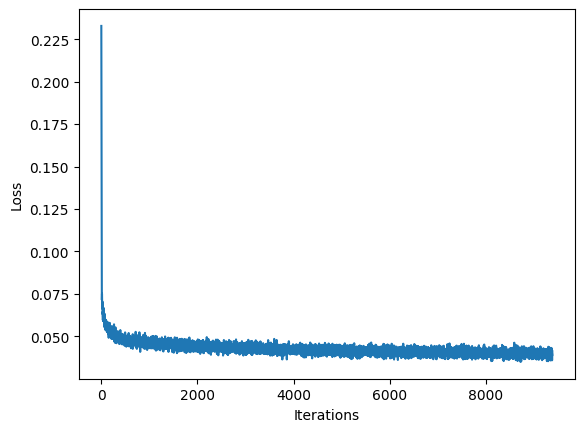

In [161]:
# Defining the Plot Style
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Plotting the losses
plt.plot(losses)

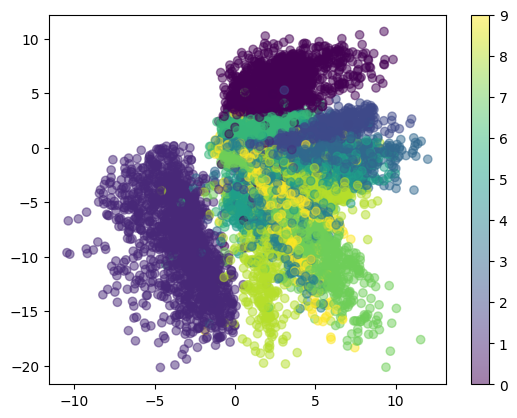

In [162]:
# Plot latent space
plot_latent(data_loader, autoencoder.encoder)
plt.savefig('latent.pdf')

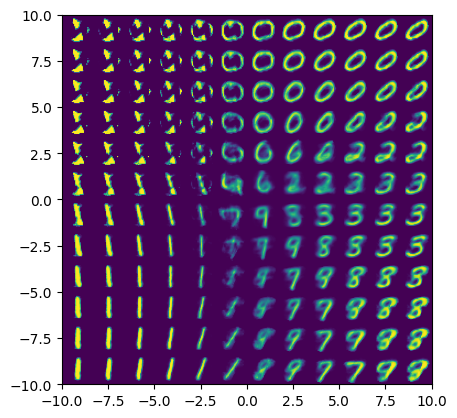

In [163]:
# Generate samples from latent space
plot_reconstructed(autoencoder.decoder,w,h)
plt.savefig('reconstruction.pdf')

# 1.2

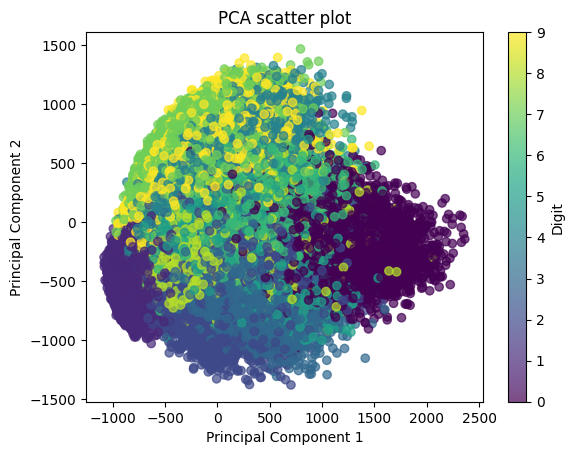

In [129]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.data.view(-1, w*h).numpy()) # .shape = (60.000, 2)

# Visualize scatter plot
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data.targets.numpy(), alpha=0.7)
plt.colorbar(label='Digit')
plt.title('PCA scatter plot', fontsize=12)
plt.xlabel('Principal Component 1', fontsize=10)
plt.ylabel('Principal Component 2', fontsize=10)
plt.show()

### Plot example images from PCA

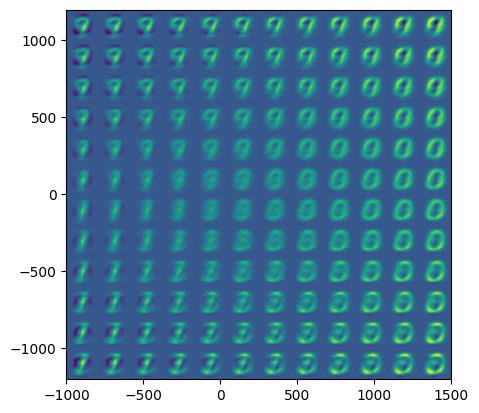

In [130]:
def plot_reconstructed_pca(pca_, w, h, r0=(-1000,1500), r1=(-1200,1200), n=12):
    img = np.zeros((n*w, n*h))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).view(1,1,2)
            x_hat = pca_.inverse_transform(z)
            x_hat = x_hat.reshape(w, h)
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed_pca(pca, w, h)

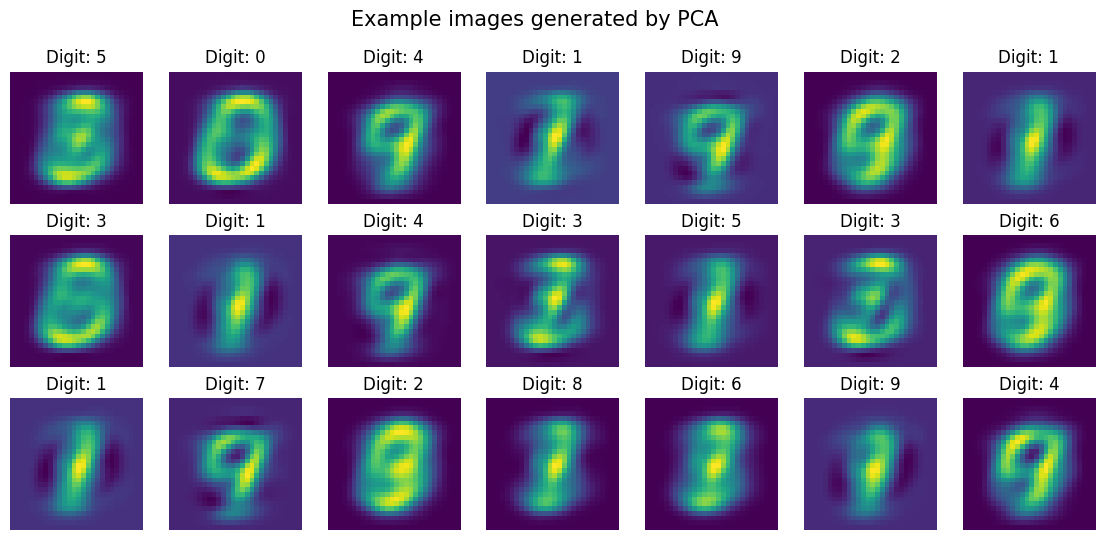

In [90]:
# Generate example images
plt.figure(figsize=(14, 6))
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(pca.inverse_transform(X_pca[i]).reshape(w, h))
    # plt.gcf().set_size_inches(30, 30)
    plt.title(f'Digit: {data.targets[i]}')
    plt.axis('off')
plt.suptitle('Example images generated by PCA', fontsize=15)
plt.show()

### Other method

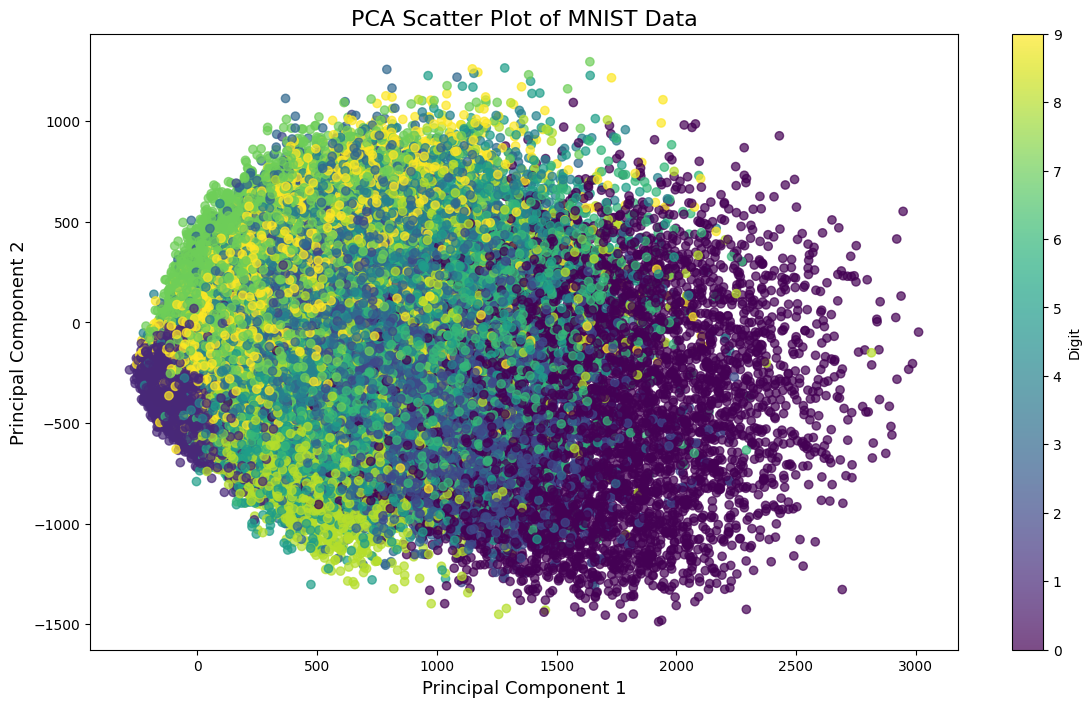

In [164]:
# X_mean = np.mean(data.data.view(-1, w*h).numpy(), axis=0)  # Mean of data
X_mean = pca.mean_
X_centered = data.data.view(-1, w*h).numpy() - X_mean  # Centered data
covariance_matrix = np.cov(X_centered, rowvar=False)  # Covariance matrix

eigenvalues = pca.explained_variance_ # = [332724.67   243283.94]
eigenvectors = pca.components_.T # .shape = (784, 2)

# Sort eigenvalues and eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_ = eigenvalues[sorted_indices]
eigenvectors_ = eigenvectors[:, sorted_indices]

# Encode data
X_pca = np.dot(X_centered, eigenvectors_[:, :2])  # Project data onto first 2 principal components


# Visualize scatter plot
plt.figure(figsize=(14, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=data.targets.numpy(), alpha=0.7)
plt.colorbar(label='Digit')
plt.title('PCA Scatter Plot of MNIST Data', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=13)
plt.ylabel('Principal Component 2', fontsize=13)
plt.show()

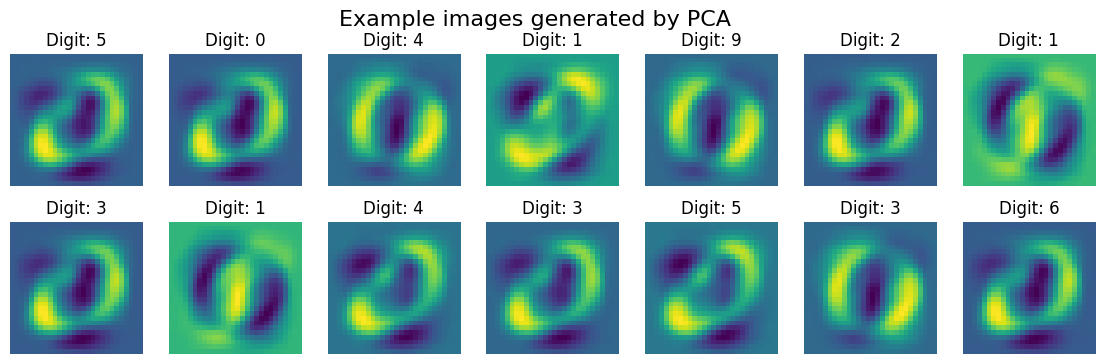

In [165]:
plt.figure(figsize=(14, 4))
for i in range(14):
    reconstructed_image = X_mean + np.dot(X_pca[i], np.sqrt(np.diag(eigenvalues_[:2])) @ eigenvectors_[:, :2].T)
    plt.subplot(2, 7, i+1)
    plt.imshow(reconstructed_image.reshape(w, h))
    plt.title(f'Digit: {data.targets[i]}')
    plt.axis('off')
plt.suptitle('Example images generated by PCA', fontsize=16)
plt.show()

# 1.3

### PCA reconstruction errors

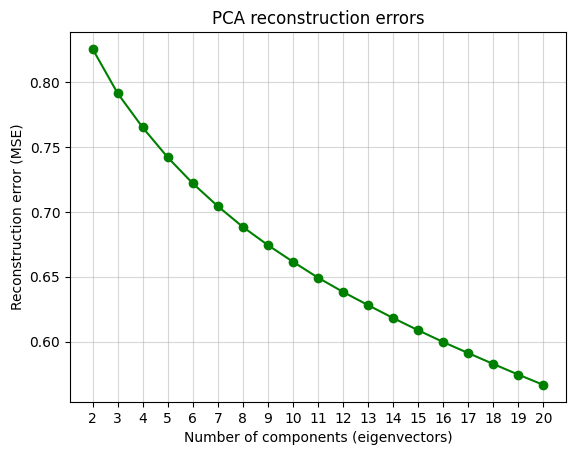

In [159]:
""" One method: Not used
data_scaled = data.data.view(len(data), -1).numpy()  / 255.0

pca_errors = []
for n_components in range(2, 21):
    pca = PCA(n_components=n_components)
    X = data_scaled
    X_pca = pca.fit_transform(X)
    X_projected = pca.inverse_transform(X_pca)
    reconstruction_error = mean_squared_error(X, X_projected)
    pca_errors.append(reconstruction_error)
"""

# scale the data before applying PCA
data = np.reshape(data.data, (len(data),-1))
s = StandardScaler()
data_scaled = s.fit_transform(data.data.numpy())

# Calculate reconstruction errors for PCA
pca_errors = []
for n_components in range(2, 21):
    pca = PCA(n_components=n_components)
    X = data_scaled
    X_pca = pca.fit_transform(X)
    X_projected = pca.inverse_transform(X_pca)
    reconstruction_error = mean_squared_error(X, X_projected)
    pca_errors.append(reconstruction_error)

# Plot reconstruction errors as a function of dimensions
plt.plot(range(2, 21), pca_errors, label='PCA Reconstruction Error', marker='o', color='green')
plt.xticks(range(2, 21))
plt.title('PCA reconstruction errors')
plt.xlabel('Number of components (eigenvectors)')
plt.ylabel('Reconstruction error (MSE)')
plt.grid(alpha=0.5)
plt.show()

### Testing higher range of PCA components

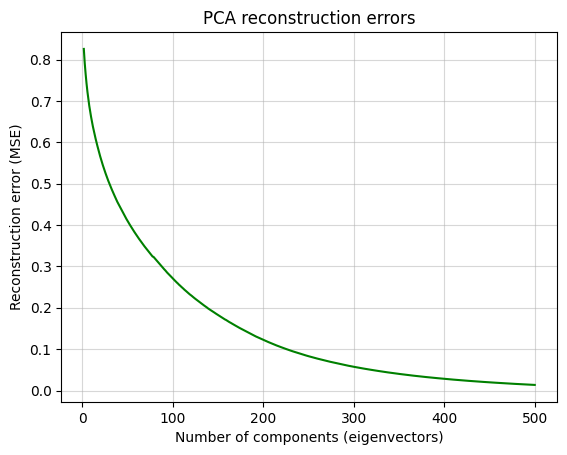

In [147]:
# scale the data before applying PCA
data = np.reshape(data.data, (len(data),-1))
s = StandardScaler()
data_scaled = s.fit_transform(data.data.numpy())

# Calculate reconstruction errors for PCA
pca_errors = []
for n_components in range(2, 501):
    pca = PCA(n_components=n_components)
    X = data_scaled
    X_pca = pca.fit_transform(X)
    X_projected = pca.inverse_transform(X_pca)
    reconstruction_error = mean_squared_error(X, X_projected)
    pca_errors.append(reconstruction_error)

# Plot reconstruction errors as a function of dimensions
plt.plot(range(2, 501), pca_errors, label='PCA Reconstruction Error', color='green')
# plt.xticks(range(2, 21))
plt.title('PCA reconstruction errors')
plt.xlabel('Number of components (eigenvectors)')
plt.ylabel('Reconstruction error (MSE)')
plt.grid(alpha=0.5)
plt.show()

### Autoencoder

In [15]:
latent_dim_range = range(2, 21)

autoencoder_errors = []
for dim3 in latent_dim_range:
    model = Autoencoder(w*h, 512, dim3)
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = torch.nn.MSELoss()
    (autoencoder, losses) = train(data_loader, model, optimizer, loss_function, epochs=20)
    autoencoder_errors.append(losses[-1]) # append last loss

0/0: 0.2339862585067749
0/100: 0.05765845999121666
0/200: 0.052545685321092606
0/300: 0.05182524770498276
0/400: 0.05133984982967377
1/0: 0.0505082942545414
1/100: 0.047621484845876694
1/200: 0.047253794968128204
1/300: 0.04872579872608185
1/400: 0.048933446407318115
2/0: 0.04592330753803253
2/100: 0.04661402851343155
2/200: 0.04431982338428497
2/300: 0.047641899436712265
2/400: 0.04613151401281357
3/0: 0.04538169130682945
3/100: 0.04649297520518303
3/200: 0.04749652370810509
3/300: 0.04598013311624527
3/400: 0.04307583346962929
4/0: 0.04818468168377876
4/100: 0.0427631214261055
4/200: 0.04693502187728882
4/300: 0.042867511510849
4/400: 0.04188418760895729
5/0: 0.04096264764666557
5/100: 0.04234037548303604
5/200: 0.04366074874997139
5/300: 0.04102605581283569
5/400: 0.042339976876974106
6/0: 0.045859530568122864
6/100: 0.042958375066518784
6/200: 0.04466330260038376
6/300: 0.04468972235918045
6/400: 0.04386167973279953
7/0: 0.042290858924388885
7/100: 0.044276345521211624
7/200: 0.042

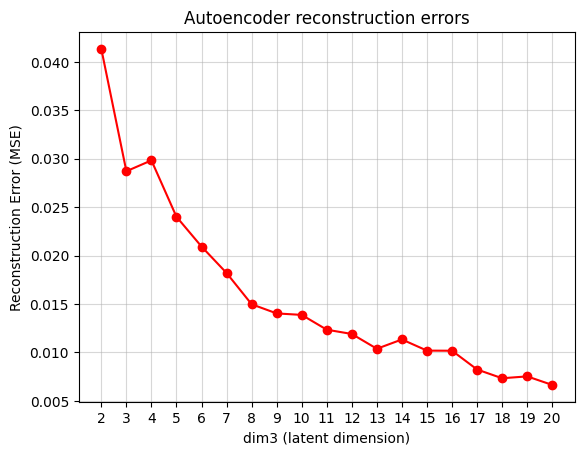

In [166]:
# Plot reconstruction errors as a function of dimensions
plt.plot(latent_dim_range, autoencoder_errors, label='Autoencoder Reconstruction Error', marker='o', color='red')
plt.title('Autoencoder reconstruction errors')
plt.xticks(latent_dim_range)
plt.xlabel('dim3 (latent dimension)')
plt.ylabel('Reconstruction Error (MSE)')
plt.grid(alpha=0.5)
plt.show()

### Plotted together

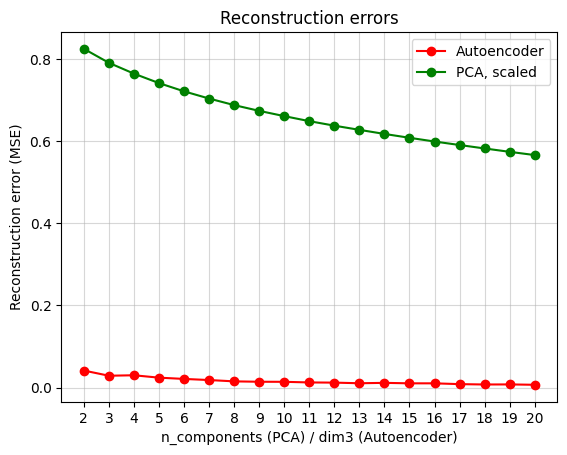

In [167]:
plt.plot(range(2,21), autoencoder_errors, label='Autoencoder', marker='o', color='red')
plt.plot(range(2,21), pca_errors, label='PCA, scaled', marker='o', color='green')
plt.title('Reconstruction errors')
plt.xticks(latent_dim_range)
plt.xlabel('n_components (PCA) / dim3 (Autoencoder)')
plt.ylabel('Reconstruction error (MSE)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()